# Exploring the data

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
from matplotlib import pyplot as plt

from helpers import *

import warnings
warnings.filterwarnings("ignore")

#### Load the dataframe containing videos from 2019 and their features

This is a big file (860 MB) so we have stored it on Google Drive. Download it from the link below and storie it as `generated/2019/2019_videos_Typo_Emojis_NegWords_Sentiment_title_desc.parquet`. It was generated by the notebook `data_processing.ipynb`.

https://drive.google.com/file/d/1RmVSw2MBq0Ps0dwcTQjqZsDAuivXbUaZ/view?usp=share_link

In [2]:
filepath = 'generated/2019/2019_videos_Typo_Emojis_NegWords_Sentiment_title_desc.parquet'
videos = pd.read_parquet(filepath, engine='fastparquet')

We check that each video has a unique identifier (column `display_id`).

In [3]:
videos.set_index(videos['display_id']).index.is_unique

True

There are videos with NaN values in some field but we do not remove them as it is not needed for our analysis.

In [4]:
nb_nan = len(videos) - len(videos.dropna())

print(f'There are {nb_nan} videos with a NaN field ({nb_nan / len(videos) :.1%} of the total).')

There are 290620 videos with a NaN field (2.3% of the total).


What fraction of the dataset do videos from 2019 respresent?

In [5]:
nb_videos_2019 = len(videos)
nb_videos_total = 73e6

print(f'Fractions of videos that are from 2019: {(nb_videos_2019 / nb_videos_total):.1%}')

Fractions of videos that are from 2019: 17.4%


What columns do we have in our dataframe?

Fields that were already present in the original dataset from Zenodo:

- `categories`
- `channel_id`
- `crawl_date`
- `dislike_count`
- `display_id`
- `duration`
- `like_count`
- `upload_date`
- `view_count`

Features we have created:

- Number of exclamation marks in the title (or the description) of the video: `count_excl_marks_title`, `count_excl_marks_description`.

- Number of words in all caps in the title (or the description) of the video: `count_upper_words_title`, `count_upper_words_description`.

- Number of negative emojis in the title (or the description) of the video: `count_negative_emojis_title`, `count_negative_emojis_description`.

- Number of (negative) words in the title (or the description) of the video: `count_words_title`, `count_negative_words_title`, `count_words_description`, `count_negative_words_description`.

- Intensity score in the title (or the description) of the sentiment 'negative', 'neutral' and 'positive' according to VADER (plus compund): `sia_negative_title`, `sia_neutral_title`, `sia_positive_title`, `sia_compound_title`, `sia_negative_description`, `sia_neutral_description`, `sia_positive_description`, `sia_compound_description`.

In [6]:
videos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12723124 entries, 0 to 12723123
Data columns (total 27 columns):
 #   Column                             Dtype         
---  ------                             -----         
 0   categories                         object        
 1   channel_id                         object        
 2   crawl_date                         datetime64[ns]
 3   dislike_count                      Int32         
 4   display_id                         object        
 5   duration                           object        
 6   like_count                         Int64         
 7   upload_date                        datetime64[ns]
 8   view_count                         Int64         
 9   count_words_title                  int64         
 10  count_negative_words_title         int64         
 11  count_words_description            int64         
 12  count_negative_words_description   int64         
 13  sia_negative_title                 float64       
 14  

Let us look at some basic statistics of the data.

In [7]:
videos.describe()

,dislike_count,like_count,view_count,count_words_title,count_negative_words_title,count_words_description,count_negative_words_description,sia_negative_title,sia_neutral_title,sia_positive_title,...,count_negative_emojis_title,count_upper_words_title,count_excl_marks_title,count_upper_words_description,count_excl_marks_description,count_negative_emojis_description,sia_negative_description,sia_neutral_description,sia_positive_description,sia_compound_description
count,12432558.0,12432558.0,12723002.0,1.272312e+07,1.272312e+07,1.272312e+07,1.272312e+07,1.272312e+07,1.272312e+07,1.272312e+07,...,1.272312e+07,1.272312e+07,1.272312e+07,1.272312e+07,1.272312e+07,1.272312e+07,1.272312e+07,1.272312e+07,1.272312e+07,1.272312e+07
mean,73.124659,1391.32889,76925.3421,9.705946e+00,2.296305e-01,6.695788e+01,9.016759e-01,5.931906e-02,8.559609e-01,8.458568e-02,...,4.667093e-04,1.458606e+00,1.775470e-01,4.513601e+00,1.178725e+00,6.151005e-04,3.275325e-02,8.174059e-01,1.124074e-01,4.532799e-01
std,1499.490853,15057.447047,1280569.519551,3.726376e+00,5.057305e-01,6.315216e+01,1.701385e+00,1.318519e-01,1.918755e-01,1.517358e-01,...,2.171093e-02,2.508519e+00,5.977196e-01,9.724559e+00,3.270381e+00,3.166011e-02,6.034231e-02,1.961744e-01,1.016459e-01,5.244420e-01
min,0.0,0.0,0.0,1.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,-1.000000e+00
25%,0.0,8.0,418.0,7.000000e+00,0.000000e+00,2.200000e+01,0.000000e+00,0.000000e+00,7.170000e-01,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,7.740000e-01,2.400000e-02,0.000000e+00
50%,3.0,57.0,2350.0,1.000000e+01,0.000000e+00,4.900000e+01,0.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,8.530000e-01,1.000000e-01,6.369000e-01
75%,15.0,355.0,13781.0,1.200000e+01,0.000000e+00,9.200000e+01,1.000000e+00,0.000000e+00,1.000000e+00,1.580000e-01,...,0.000000e+00,2.000000e+00,0.000000e+00,4.000000e+00,1.000000e+00,0.000000e+00,4.400000e-02,9.270000e-01,1.680000e-01,9.256000e-01
max,1555392.0,11046932.0,1578557905.0,3.400000e+01,7.000000e+00,6.000000e+02,5.900000e+01,1.000000e+00,1.000000e+00,1.000000e+00,...,2.000000e+00,2.400000e+01,9.000000e+01,4.260000e+02,4.976000e+03,1.400000e+01,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00


### Look at the distribution of the features

We look at ratios since what matters for the negativity is the fraction of negative words (etc.) and not the absolute count.

In [8]:
# Prepare the field types (this will help us plot the data)

type_text_desc = ['description'] * len(videos)
type_text_title = ['title'] * len(videos)
type_text = np.concatenate((type_text_desc, type_text_title), None)

#### Typography of the text

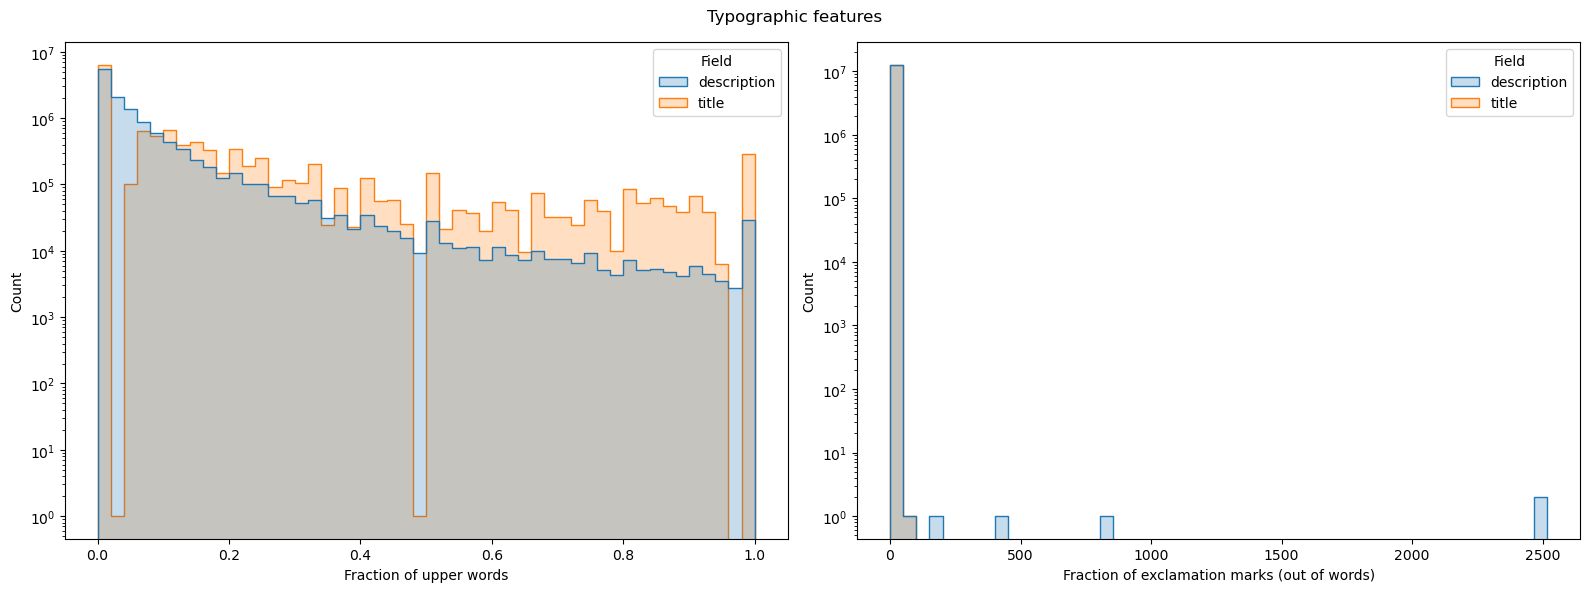

In [9]:
# Compute the ratios

ratio_excl_title = videos['count_excl_marks_title'] / videos['count_words_title']
ratio_excl_description = videos['count_excl_marks_description'] / videos['count_words_description']
ratio_excl = np.concatenate((ratio_excl_description, ratio_excl_title), None)
# Note: The ratio nb_exclamation_marks / nb_words is maybe not the best choice, we might change it later on.

ratio_upper_title = videos['count_upper_words_title']/videos['count_words_title']
ratio_upper_description = videos['count_upper_words_description']/videos['count_words_description']
ratio_upper_words = np.concatenate((ratio_upper_description, ratio_upper_title), None)


# Plot

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16,6))

ratio_typo = pd.DataFrame({
    'Field': type_text,
    'Fraction of exclamation marks (out of words)': ratio_excl,
    'Fraction of upper words': ratio_upper_words,
})

sns.histplot(ratio_typo, x='Fraction of exclamation marks (out of words)', bins=50, hue="Field", element="step", ax=axes[1]).set(yscale ='log')
sns.histplot(ratio_typo, x='Fraction of upper words', bins=50, hue="Field", element="step", ax=axes[0]).set(yscale ='log')

fig.suptitle('Typographic features')
plt.tight_layout()
plt.show()

#### Emojis

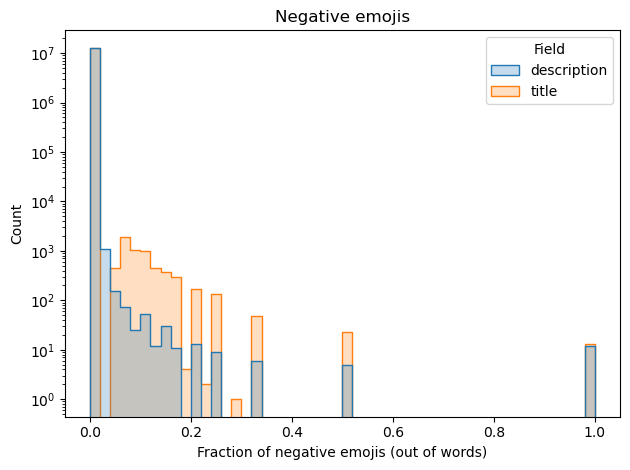

In [10]:
# Compute the ratios

ratio_emojis_title = videos['count_negative_emojis_title'] / videos['count_words_title']
ratio_emojis_description = videos['count_negative_emojis_description'] / videos['count_words_description']
ratio_emojis = np.concatenate((ratio_emojis_description, ratio_emojis_title), None)


# Plot

ratio_emojis = pd.DataFrame({
    'Field': type_text,
    'Fraction of negative emojis (out of words)': ratio_emojis
})

fig = plt.subplot()
sns.histplot(ratio_emojis, x='Fraction of negative emojis (out of words)', bins=50, hue="Field", element="step").set(yscale ='log')

fig.set_title('Negative emojis')
plt.tight_layout()
plt.show()

#### Negative words

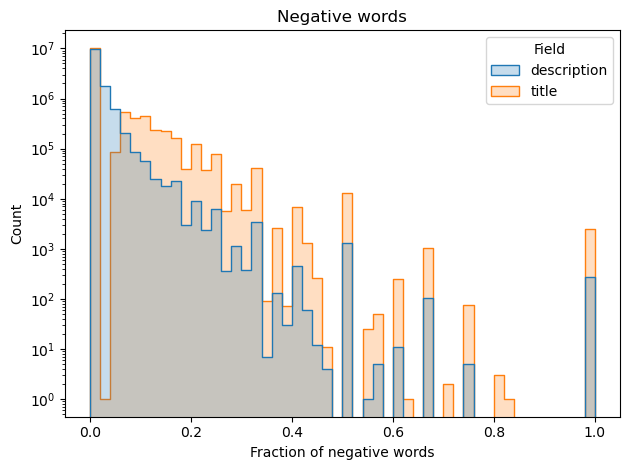

In [11]:
# Compute the ratios

ratio_neg_words_title = videos['count_negative_words_title']/videos['count_words_title']
ratio_neg_words_description = videos['count_negative_words_description']/videos['count_words_description']


# Plot

ratio_neg_words = pd.DataFrame({
    'Field': type_text,
    'Fraction of negative words': np.concatenate((ratio_neg_words_description, ratio_neg_words_title), None)
})

fig = plt.subplot()
sns.histplot(ratio_neg_words, x='Fraction of negative words', bins=50, hue="Field", element="step").set(yscale ='log')

fig.set_title('Negative words')
plt.tight_layout()
plt.show()

#### Sentiment intensity

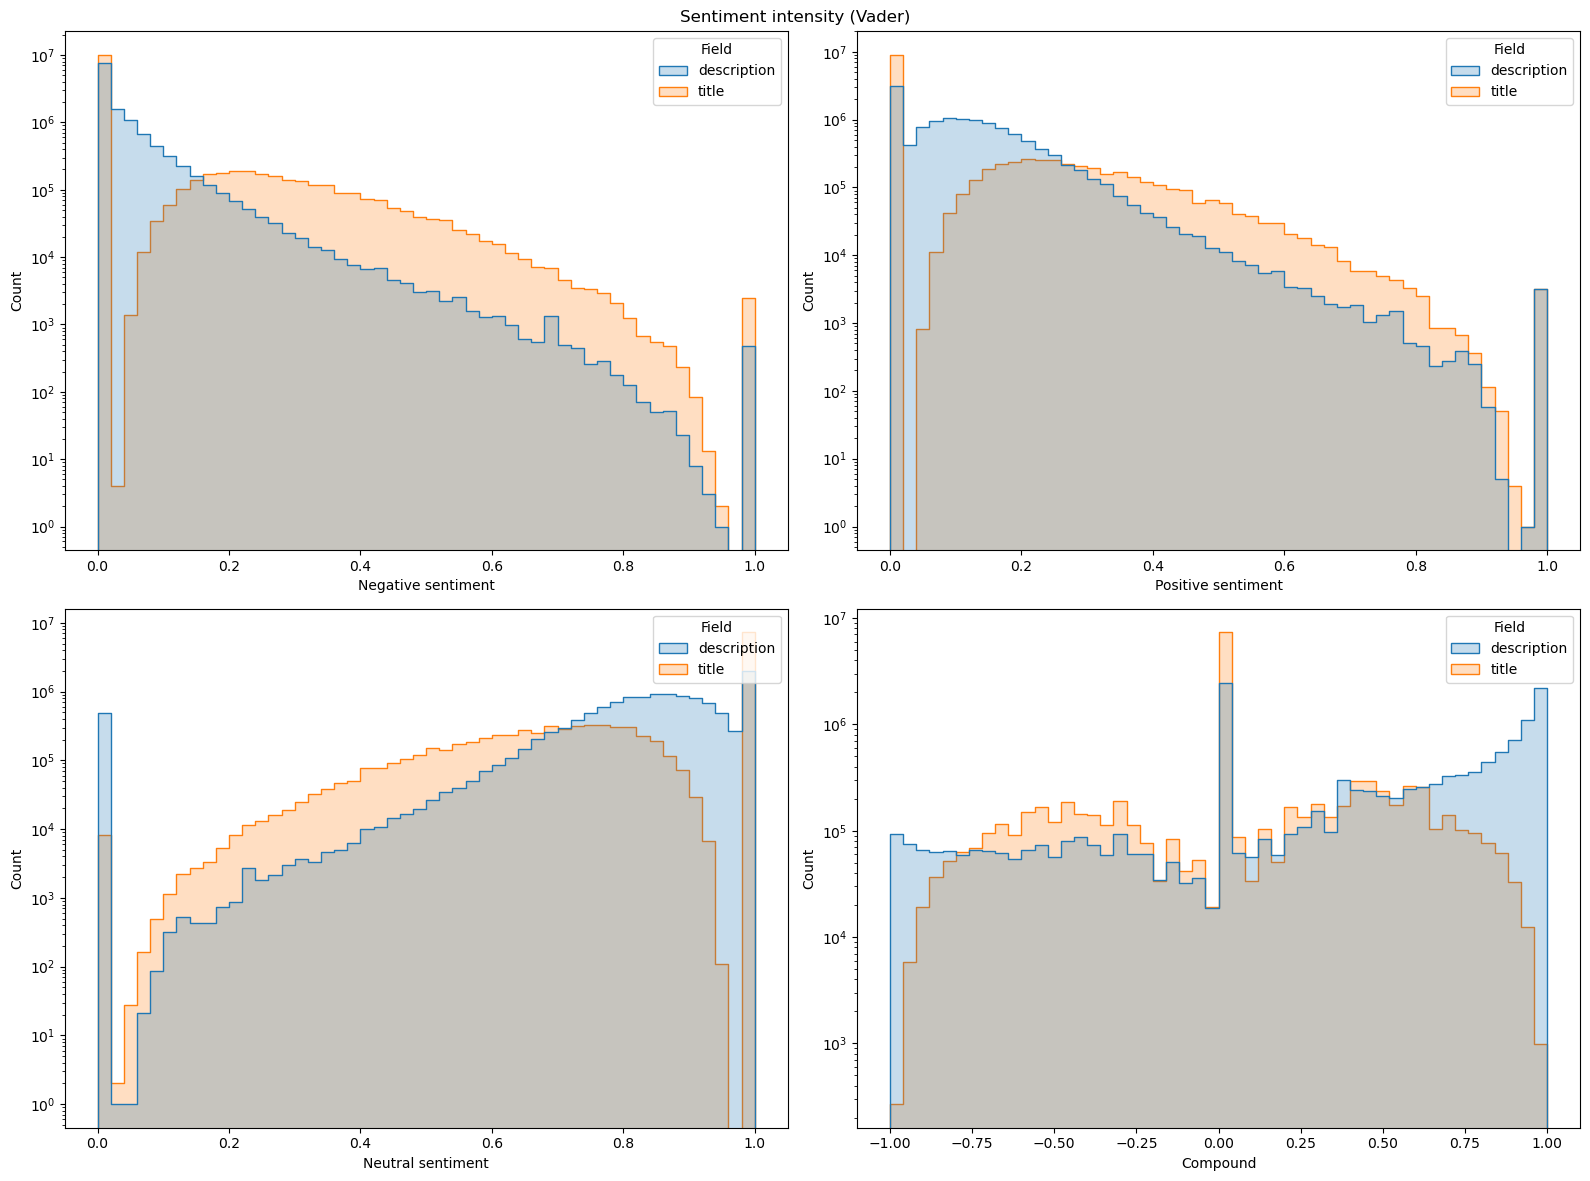

In [12]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(16,12))

sentiment = pd.DataFrame({
    'Field': type_text,
    'Negative sentiment': np.concatenate((videos['sia_negative_description'], videos['sia_negative_title']), None),
    'Positive sentiment': np.concatenate((videos['sia_positive_description'], videos['sia_positive_title']), None),
    'Neutral sentiment': np.concatenate((videos['sia_neutral_description'], videos['sia_neutral_title']), None),
    'Compound': np.concatenate((videos['sia_compound_description'], videos['sia_compound_title']), None)

})

sns.histplot(sentiment, x='Negative sentiment', bins=50, hue="Field", element="step", ax=axes[0, 0]).set(yscale ='log')
sns.histplot(sentiment, x='Positive sentiment', bins=50, hue="Field", element="step", ax=axes[0, 1]).set(yscale ='log')
sns.histplot(sentiment, x='Neutral sentiment', bins=50, hue="Field", element="step", ax=axes[1, 0]).set(yscale ='log')
sns.histplot(sentiment, x='Compound', bins=50, hue="Field", element="step", ax=axes[1, 1]).set(yscale ='log')

fig.suptitle('Sentiment intensity (Vader)')
plt.tight_layout()
plt.show()

#### Combine timeseries and videos to get ratios 

For each video, we want to get the ratio of like by subscribers of the channel that uploaded the video. As well as the ratio of dislike by subscribers, and views by total views of the channel. To do this, we need to merge the timeseries dataframe and the videos features dataframe on the date, grouping them by channel id.

Since we want to get the most accurate number of subscribers at the time of upload of the given video, we perform a nearest time merge, where we only merge on the entry of timeseries that has the closest datetime to the upload date, given a tolerance of one week (as the timeseries analysis was conducted per week). 

First step is to load the timeseries and filter out the years that are not used in our study (here we only keep 2019 for the moment)

In [13]:
df_timeseries = pd.read_csv("data/df_timeseries_en.tsv", sep="\t")
df_timeseries_2019 = df_timeseries[pd.to_datetime(df_timeseries["datetime"]).dt.year == 2019]

In [17]:
df_timeseries_2019.head(5)

,channel,category,nearest_time,views,delta_views,subs,delta_subs,videos,delta_videos,activity
79,UCBJuEqXfXTdcPSbGO9qqn1g,Film and Animation,2019-01-06 23:00:00,1.681183e+07,72195.713542,62296.364583,88.494792,24,0,0
80,UCBJuEqXfXTdcPSbGO9qqn1g,Film and Animation,2019-01-13 23:00:00,1.687644e+07,64606.010417,62363.562500,67.197917,24,0,0
81,UCBJuEqXfXTdcPSbGO9qqn1g,Film and Animation,2019-01-20 23:00:00,1.693356e+07,57117.354167,62432.989583,69.427083,24,0,0
82,UCBJuEqXfXTdcPSbGO9qqn1g,Film and Animation,2019-01-27 23:00:00,1.699153e+07,57972.250000,62476.739583,43.750000,26,2,2
83,UCBJuEqXfXTdcPSbGO9qqn1g,Film and Animation,2019-02-03 23:00:00,1.709303e+07,101502.713542,62749.244792,272.505208,26,0,2


Then, we rename the columns accordingly for the merge asof

In [18]:
#df_timeseries_2019["datetime"] = pd.to_datetime(df_timeseries_2019['datetime'])
df_timeseries_2019.rename({"datetime": "nearest_time"}, axis=1, inplace=True)
videos.rename({"upload_date": "nearest_time"}, axis=1, inplace=True)
df_timeseries_2019.rename({"channel": "channel_id"}, axis=1, inplace=True)

In [20]:
videos_on_date_by_channel = pd.merge_asof(videos.sort_values("nearest_time"),df_timeseries_2019.sort_values("nearest_time"),on="nearest_time",by="channel_id",allow_exact_matches=True,direction="nearest",tolerance=pd.Timedelta(1,unit="W"))

Since some videos were uploaded by channels that are not in the timeseries, we end up with NaN values. We decided to remove the rows that have these NaN values.

In [21]:
# approx 1M missing values (channels that are in metadata but not in timeseries)
videos_on_date_by_channel.dropna(axis=0,inplace=True)

We create new columns for the ratios

In [22]:
def create_ratio_column(df, new_col,col1,col2):
        df[new_col] = df[col1]/df[col2]

create_ratio_column(videos_on_date_by_channel,"like_count_by_subs","like_count","subs")
create_ratio_column(videos_on_date_by_channel,"dislike_count_by_subs","dislike_count","subs")
create_ratio_column(videos_on_date_by_channel,"view_count_by_channel_views","view_count","views")

Let's now plot the distribution of the number of views between all the videos and the distribution of the number of subscribers between all the channels. In fact, knowing this information will helps us decide what kind of normalization should be use in the rest of the project.

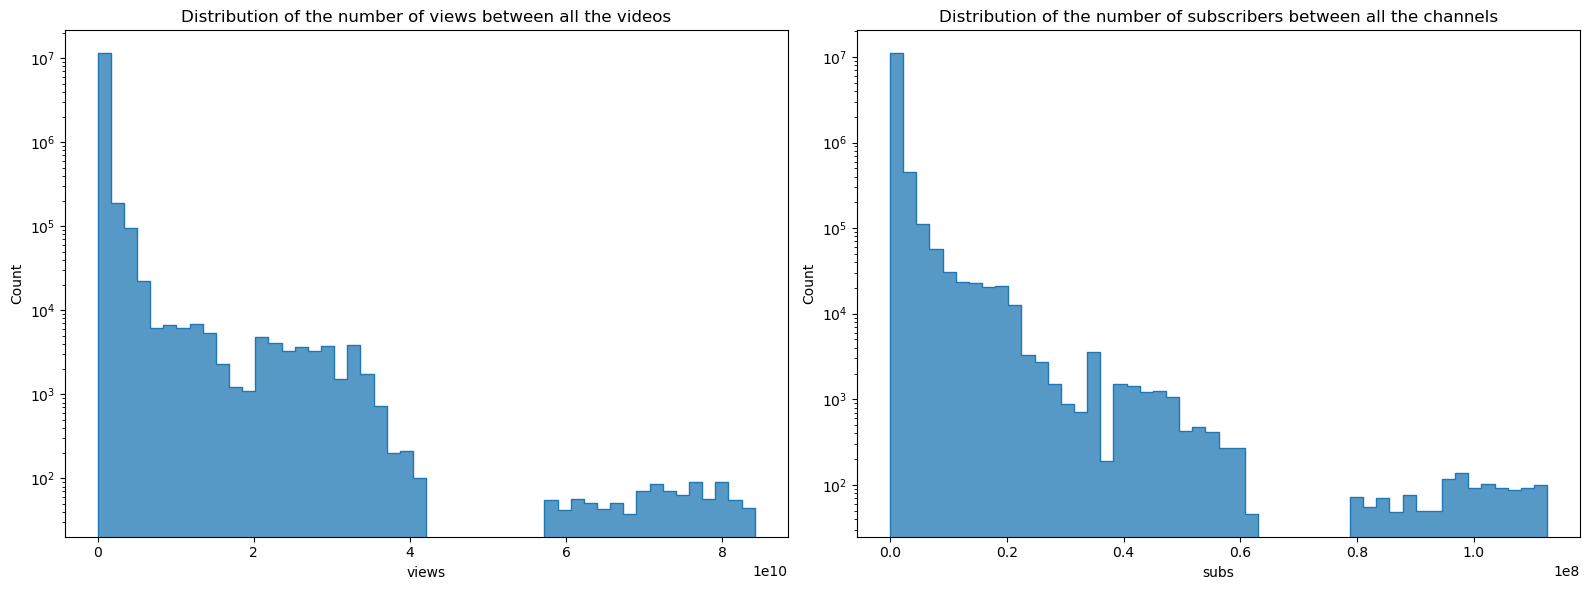

In [23]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16,6))

videos_on_date_by_channel = videos_on_date_by_channel[videos_on_date_by_channel["views"] > 0]
videos_on_date_by_channel = videos_on_date_by_channel[videos_on_date_by_channel["subs"] > 0]

sns.histplot(videos_on_date_by_channel, x="views", bins=50, element="step", ax=axes[0])
sns.histplot(videos_on_date_by_channel, x="subs", bins=50, element="step", ax=axes[1])

axes[0].set(yscale ='log')
axes[0].set_title('Distribution of the number of views between all the videos')

axes[1].set(yscale ='log')
axes[1].set_title('Distribution of the number of subscribers between all the channels')

plt.tight_layout()
plt.show()